In [124]:
!pip install torch-summary

import torchvision
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torchsummary import summary
import torchmetrics

In [125]:

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

len trainset 50000 type trainset <class 'torchvision.datasets.cifar.CIFAR10'>
len testset 10000 type trainset <class 'torchvision.datasets.cifar.CIFAR10'>
<class 'tuple'>


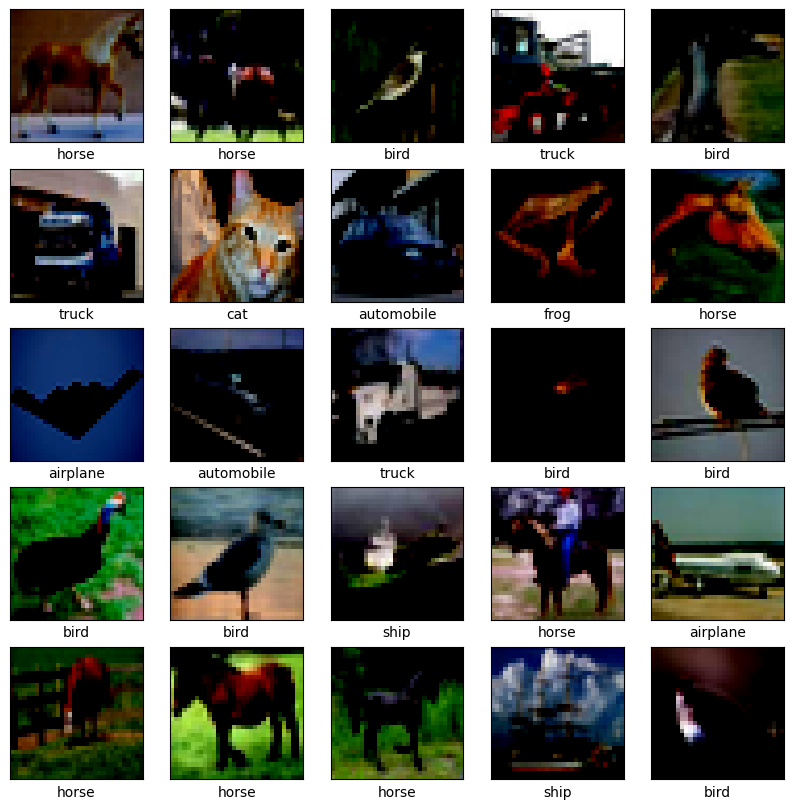

In [126]:
import numpy as np
# TODO : EDA

# SHAPES
print('len trainset', len(trainset), 'type trainset', type(trainset))
print('len testset', len(testset), 'type trainset', type(testset))

# every sample is a tuple like (pics, label)
print(type(trainset[0]))

# Generate 25 random integers between 0 and 100
# let's vizualise some stuff
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
random_integers = np.random.randint(0, 20000, size=25)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_integers):
  image, label_index = trainset[idx][0], trainset[idx][1]
  image = np.transpose(image, (1, 2, 0))
  label_name = class_names[label_index]
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image)
  plt.xlabel(label_name)

plt.show()

In [127]:
# TODO : Create your DataModule

class CIFARdm(pl.LightningDataModule):
  def __init__(self, dataset_path, batch_size, transform):
    super().__init__()
    self.dataset_path = dataset_path
    self.batch_size = batch_size
    self.transform = transform

  def prepare_data(self):
    torchvision.datasets.CIFAR10(root=self.dataset_path, train=True, download=True)
    torchvision.datasets.CIFAR10(root=self.dataset_path, train=False, download=True)

  def setup(self, stage=None):
    if stage == 'fit' or stage is None:
      dset = torchvision.datasets.CIFAR10(root=self.dataset_path, train=True, transform=self.transform)

      train_size = int(0.8 * len(dset)) # splitting the dataset in 80/20 for validation set

      test_size = len(dset) - train_size

      mnist_train, mnist_valid =  torch.utils.data.random_split(dset, [train_size, test_size])

      self.train_dset, self.val_dset = mnist_train, mnist_valid
    if stage == "test" or stage is None:

      self.test_dset = torchvision.datasets.CIFAR10(root=self.dataset_path, train=False,
                                          transform=self.transform)


  def train_dataloader(self):
    return DataLoader(self.train_dset, self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.val_dset, self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.test_dset, self.batch_size)



In [128]:
# TODO : Create your Module

# normally this lightning module is made to perform on any model

class simpleConvModel(nn.Module): # my own model that perform like shit
  def __init__(self, output_shape):
    super().__init__()

    self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1568, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
            nn.Softmax()
        )
    
  def forward(self, x):
    x = self.conv_layers(x)
    x = self.linear_layers(x)
    return x

class CIFARClassifier(pl.LightningModule):
    def __init__(self, model, output_shape):
      
        super(CIFARClassifier, self).__init__()
        # what is the output_shape of your model ?
        # (1, ) because softmax + no hot encode + cross-entropy loss

        self.model = model
        self.nb_test_batch = 0
        self.final_acc = 0

        self.loss_func = nn.CrossEntropyLoss()
        self.output_shape = output_shape
        self.save_hyperparameters()
        # TODO : Define your model here, be careful, your model will be an instance of the class. Watch  out for the input data.
        


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # TODO : Choose your optimizer : https://pytorch.org/docs/stable/optim.html
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.0001)
        return optimizer

    def step(self, batch, batch_idx):
        x,y = batch
        y_pred = self(x)
        loss = self.loss_func(y_pred, y)
        acc = ( y_pred.argmax() == y ).sum() / len(batch)

        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.step(batch, batch_idx)
        self.log('train_acc', acc)
        self.log('train_loss', loss)
        return loss


    def validation_step(self, batch, batch_idx):
        loss, acc = self.step(batch, batch_idx)
        self.log('val_acc', acc)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc = self.step(batch, batch_idx)
        self.final_acc += acc
        self.nb_test_batch += 1
        
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def test_epoch_start(self):
        self.final_acc = 0

    def on_test_epoch_end(self):
        self.acc = self.final_acc / self.nb_test_batch
        self.log('Final Accuracy', self.final_acc)




In [129]:
# now importing the ConvNext model
model = torchvision.models.convnext_small(weights='DEFAULT')

In [130]:
summary(model)

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       4,704
|    |    └─LayerNorm2d: 3-2                  192
|    └─Sequential: 2-2                        --
|    |    └─CNBlock: 3-3                      79,296
|    |    └─CNBlock: 3-4                      79,296
|    |    └─CNBlock: 3-5                      79,296
|    └─Sequential: 2-3                        --
|    |    └─LayerNorm2d: 3-6                  192
|    |    └─Conv2d: 3-7                       73,920
|    └─Sequential: 2-4                        --
|    |    └─CNBlock: 3-8                      306,048
|    |    └─CNBlock: 3-9                      306,048
|    |    └─CNBlock: 3-10                     306,048
|    └─Sequential: 2-5                        --
|    |    └─LayerNorm2d: 3-11                 384
|    |    └─Conv2d: 3-12                      295,296
|    └─Sequential: 2-6

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       4,704
|    |    └─LayerNorm2d: 3-2                  192
|    └─Sequential: 2-2                        --
|    |    └─CNBlock: 3-3                      79,296
|    |    └─CNBlock: 3-4                      79,296
|    |    └─CNBlock: 3-5                      79,296
|    └─Sequential: 2-3                        --
|    |    └─LayerNorm2d: 3-6                  192
|    |    └─Conv2d: 3-7                       73,920
|    └─Sequential: 2-4                        --
|    |    └─CNBlock: 3-8                      306,048
|    |    └─CNBlock: 3-9                      306,048
|    |    └─CNBlock: 3-10                     306,048
|    └─Sequential: 2-5                        --
|    |    └─LayerNorm2d: 3-11                 384
|    |    └─Conv2d: 3-12                      295,296
|    └─Sequential: 2-6

In [131]:
# TODO : Using torchsummary, send an image of the same size as a sample of CIFAR-10
test = summary(model, torch.unsqueeze(testset[0][0], dim=0)) # ... = input shape as a tuple (1, C, H, W)


Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 768, 1, 1]           --
|    └─Conv2dNormActivation: 2-1              [-1, 96, 8, 8]            --
|    |    └─Conv2d: 3-1                       [-1, 96, 8, 8]            4,704
|    |    └─LayerNorm2d: 3-2                  [-1, 96, 8, 8]            192
|    └─Sequential: 2-2                        [-1, 96, 8, 8]            --
|    |    └─CNBlock: 3-3                      [-1, 96, 8, 8]            79,296
|    |    └─CNBlock: 3-4                      [-1, 96, 8, 8]            79,296
|    |    └─CNBlock: 3-5                      [-1, 96, 8, 8]            79,296
|    └─Sequential: 2-3                        [-1, 192, 4, 4]           --
|    |    └─LayerNorm2d: 3-6                  [-1, 96, 8, 8]            192
|    |    └─Conv2d: 3-7                       [-1, 192, 4, 4]           73,920
|    └─Sequential: 2-4                        [-1, 192, 4, 4]           --

In [132]:
# I prefer this output
print(model)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [133]:
# trying to replace last layer by a linear that output a vector of 10 + softmax to fit with my CrossEntropy Loss

input_features = model.classifier[2].in_features # nb input features last layer

# here I'm replacing the last layer by a Linear layer outputing a vector of 10 to match CIFAR classes followed by a softmax layer to match the CrossEntropy function
model.classifier[2] = nn.Sequential(
 nn.Linear(input_features, 10),
 nn.Softmax()   
)

# then trying to freeze all the layers except the last one
# I start by freezing all layers
# OLD for params in model.parameters():

for params in model.features.parameters():
  params.requires_grad = False

# then unfreezing the layer I just modified
# model.classifier[2].requires_grad = True

In [134]:
# TODO : Train
# TODO : Train
output_size = 1
batch_size = 32

path = './dataset/CIFAR10'

tb_logger = pl_loggers.TensorBoardLogger("introduction_to_Lightning_2", name="CIFAR")

dm = CIFARdm(path, batch_size, transform)


pl_model = CIFARClassifier(model, output_size)

trainer = pl.Trainer(max_epochs=10,accelerator='auto',logger=tb_logger)

trainer.fit(pl_model, dm)

/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ConvNeXt         | 49.5 M
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
9.2 K     Trainable params
49.5 M    Non-trainable params
49.5 M    Total params
197.850   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1250/1250 [00:39<00:00, 31.97it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1250/1250 [00:39<00:00, 31.74it/s, v_num=0]


In [135]:
# test
trainer.test(pl_model, dm)

Files already downloaded and verified
Files already downloaded and verified


/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 313/313 [00:07<00:00, 40.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Final Accuracy                17.0
        test_acc            0.0544000044465065
        test_loss           2.0718865394592285
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.0718865394592285,
  'test_acc': 0.0544000044465065,
  'Final Accuracy': 17.0}]

In [136]:
%reload_ext tensorboard
%tensorboard --logdir "./introduction_to_Lightning_2/CIFAR/version_`0"

Reusing TensorBoard on port 6006 (pid 32274), started 0:23:06 ago. (Use '!kill 32274' to kill it.)